1. Data Loading

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

In [22]:
confirmed_df = pd.read_csv(r"covid_19_confirmed_v1.csv")
deaths_df = pd.read_csv(r"covid_19_deaths_v1.csv")
recovered_df = pd.read_csv(r"covid_19_recovered_v1.csv")



print("Confirmed Cases:\n", confirmed_df.head())
print("Deaths:\n", deaths_df.head())
print("Recovered Cases:\n", recovered_df.head())

Confirmed Cases:
   Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   
3            NaN        Andorra  42.50630   1.521800        0        0   
4            NaN         Angola -11.20270  17.873900        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  5/20/21  5/21/21  5/22/21  \
0        0        0        0        0  ...    64575    65080    65486   
1        0        0        0        0  ...   132118   132153   132176   
2        0        0        0        0  ...   126156   126434   126651   
3        0        0        0        0  ...    13569    13569    13569   
4        0        0        0        0  ...    31661    31909    32149   

   5/23/21  5/24/21  5/25/21  5/26/21  5/27/21  5/28/21  5/29/21  
0    65728    66275    66903   

2. Data Exploration

2.1 Structure of Each Dataset

In [23]:
# Check structure
print("Confirmed Cases Dataset:")
print(f"Rows: {confirmed_df.shape[0]}, Columns: {confirmed_df.shape[1]}")
print(confirmed_df.dtypes)

print("\nDeaths Dataset:")
print(f"Rows: {deaths_df.shape[0]}, Columns: {deaths_df.shape[1]}")
print(deaths_df.dtypes)

print("\nRecovered Cases Dataset:")
print(f"Rows: {recovered_df.shape[0]}, Columns: {recovered_df.shape[1]}")
print(recovered_df.dtypes)

Confirmed Cases Dataset:
Rows: 276, Columns: 498
Province/State     object
Country/Region     object
Lat               float64
Long              float64
1/22/20             int64
                   ...   
5/25/21             int64
5/26/21             int64
5/27/21             int64
5/28/21             int64
5/29/21             int64
Length: 498, dtype: object

Deaths Dataset:
Rows: 276, Columns: 498
Province/State     object
Country/Region     object
Lat               float64
Long              float64
1/22/20             int64
                   ...   
5/25/21             int64
5/26/21             int64
5/27/21             int64
5/28/21             int64
5/29/21             int64
Length: 498, dtype: object

Recovered Cases Dataset:
Rows: 261, Columns: 498
Province/State     object
Country/Region     object
Lat               float64
Long              float64
1/22/20             int64
                   ...   
5/25/21             int64
5/26/21             int64
5/27/21             int64


2.2 Plots of Confirmed Cases Over Time for Top Countries

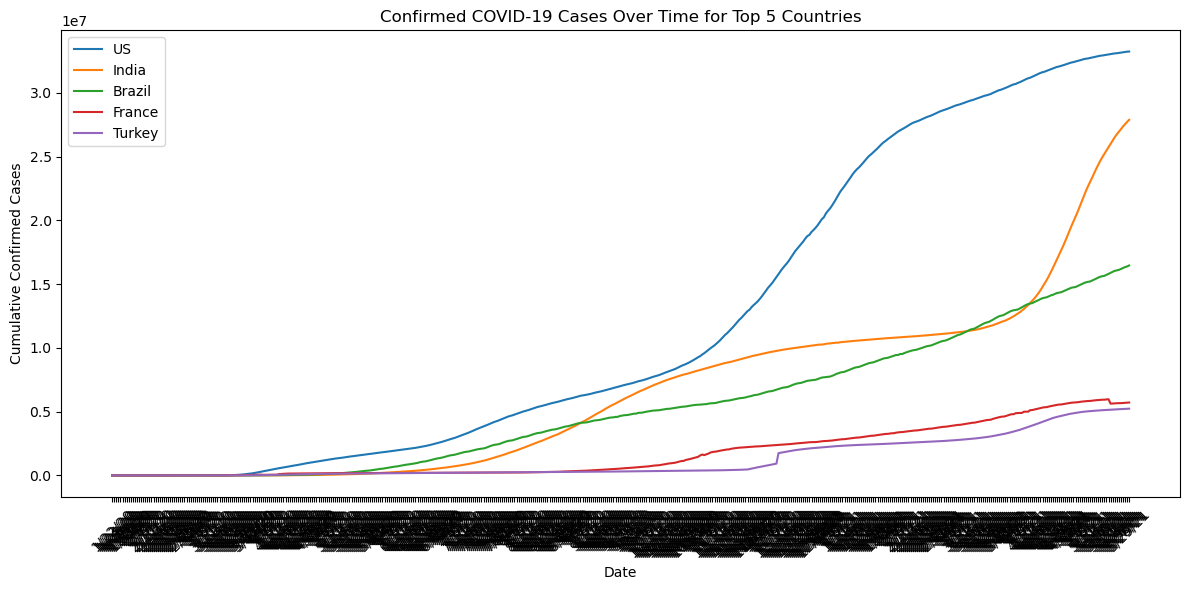

In [31]:
# First, we need to melt the date columns to create a proper time series
date_columns = confirmed_df.columns[4:]  # Assuming first 4 columns are metadata

# Aggregate by country (sum over provinces)
confirmed_by_country = confirmed_df.drop(['Province/State', 'Lat', 'Long'], axis=1).groupby('Country/Region').sum()

# Select top 5 countries by total cases on the last date
top_countries = confirmed_by_country.iloc[:, -1].nlargest(5).index

plt.figure(figsize=(12, 6))
for country in top_countries:
    plt.plot(date_columns, confirmed_by_country.loc[country], label=country)
    
plt.title('Confirmed COVID-19 Cases Over Time for Top 5 Countries')
plt.xlabel('Date')
plt.ylabel('Cumulative Confirmed Cases')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('top5_countries_cases.png')
plt.show()

2.3 Generate plots of confirmed cases over time for China

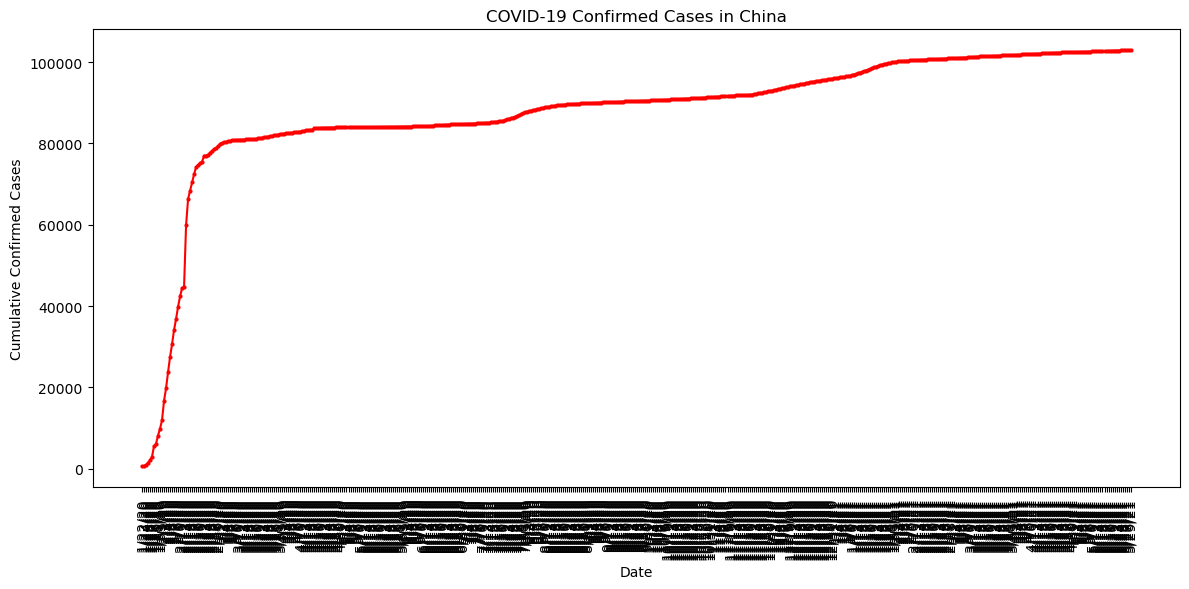

In [ ]:
china_data = confirmed_df[confirmed_df['Country/Region'] == 'China']
china_total = china_data.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1).sum()

plt.figure(figsize=(12, 6))
plt.plot(date_columns, china_total, marker='o', markersize=2, linewidth=1.5, color='red')
plt.title('COVID-19 Confirmed Cases in China')
plt.xlabel('Date')
plt.ylabel('Cumulative Confirmed Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('china_cases.png')
plt.show()

3. Handling Missing Data

In [36]:
print("\n3. Missing Data Analysis:")
for df_name, df in [("Confirmed", confirmed_df), ("Deaths", deaths_df), ("Recovered", recovered_df)]:
    missing_values = df.isnull().sum().sum()
    print(f"{df_name} dataset missing values: {missing_values}")
    
    # Forward fill for time series data (if needed)
    if missing_values > 0:
        # For the date columns
        date_cols = df.columns[4:]
        df[date_cols] = df[date_cols].fillna(method='bfill', axis=1)
        
        # For other columns
        df.fillna({'Province/State': 'Unknown'}, inplace=True)
        
        print(f"After imputation, missing values: {df.isnull().sum().sum()}")


3. Missing Data Analysis:
Confirmed dataset missing values: 0
Deaths dataset missing values: 0
Recovered dataset missing values: 0


In [35]:
# 3. Handling Missing Data
print("\n3. Missing Data Analysis:")
for df_name, df in [("Confirmed", confirmed_df), ("Deaths", deaths_df), ("Recovered", recovered_df)]:
    missing_values = df.isnull().sum().sum()
    print(f"{df_name} dataset missing values: {missing_values}")
    
    # For debugging, identify where the missing values are
    missing_cols = df.columns[df.isnull().any()].tolist()
    print(f"Columns with missing values: {missing_cols}")
    
    # First, handle missing Province/State values
    df['Province/State'] = df['Province/State'].fillna("All Provinces")
    
    # For numeric data in date columns
    date_cols = df.columns[4:]  # Assuming first 4 columns are metadata
    
    # Apply forward fill (for time series data)
    df[date_cols] = df[date_cols].ffill(axis=1)
    
    # If there are still NaNs, apply backward fill
    df[date_cols] = df[date_cols].bfill(axis=1)
    
    # For any remaining NaNs (if any), fill with zeros
    df[date_cols] = df[date_cols].fillna(0)
    
    # Check if any missing values remain
    remaining_missing = df.isnull().sum().sum()
    print(f"After imputation, missing values: {remaining_missing}")
    
    # If there are still missing values, identify them
    if remaining_missing > 0:
        print("Columns still with missing values:")
        for col in df.columns:
            if df[col].isnull().any():
                print(f"- {col}: {df[col].isnull().sum()} missing values")


3. Missing Data Analysis:
Confirmed dataset missing values: 0
Columns with missing values: []
After imputation, missing values: 0
Deaths dataset missing values: 0
Columns with missing values: []
After imputation, missing values: 0
Recovered dataset missing values: 0
Columns with missing values: []
After imputation, missing values: 0


4. Data Cleaning - Replace blank values in province column

In [39]:
for df in [confirmed_df, deaths_df, recovered_df]:
    df['Province/State'] = df['Province/State'].fillna("All Provinces")

5.1 Analyze peak daily new cases in Germany, France, and Italy

In [38]:
countries_of_interest = ['Germany', 'France', 'Italy']
daily_cases = {}

for country in countries_of_interest:
    country_data = confirmed_df[confirmed_df['Country/Region'] == country].drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1).sum()
    # Calculate daily new cases (difference between consecutive days)
    daily_new = country_data.diff().fillna(0)
    daily_cases[country] = daily_new
    
    peak_day_idx = daily_new.idxmax()
    peak_value = daily_new.max()
    print(f"\n{country} peak daily cases: {peak_value:.0f} on {peak_day_idx}")


Germany peak daily cases: 49044 on 12/30/20

France peak daily cases: 117900 on 4/11/21

Italy peak daily cases: 40902 on 11/13/20


Visualize daily new cases

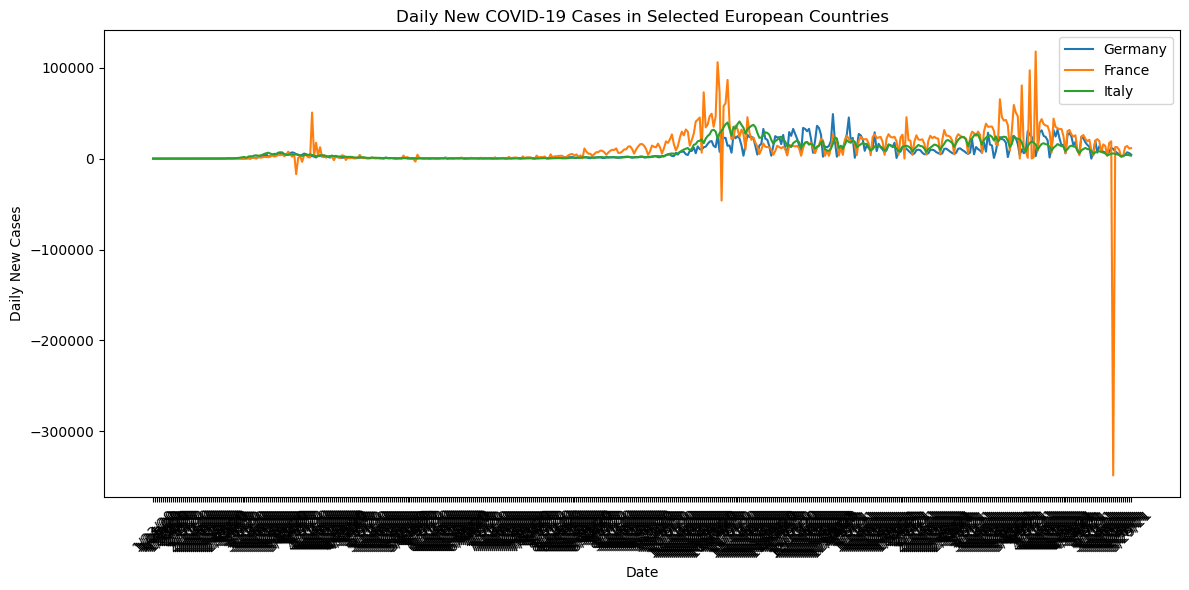

In [ ]:
plt.figure(figsize=(12, 6))
for country, data in daily_cases.items():
    plt.plot(date_columns[1:], data.values[1:], label=country)

plt.title('Daily New COVID-19 Cases in Selected European Countries')
plt.xlabel('Date')
plt.ylabel('Daily New Cases')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('daily_new_cases_europe.png')
plt.show()

5.2 Compare recovery rates between Canada and Australia on Dec 31, 2020

In [ ]:
target_date = '12/31/20'  # Format may need adjustment based on your dataset
countries_to_compare = ['Canada', 'Australia']

if target_date in confirmed_df.columns:
    recovery_rates = {}
    
    for country in countries_to_compare:
        confirmed = confirmed_df[confirmed_df['Country/Region'] == country][target_date].sum()
        recovered = recovered_df[recovered_df['Country/Region'] == country][target_date].sum()
        
        if confirmed > 0:
            recovery_rate = (recovered / confirmed) * 100
            recovery_rates[country] = recovery_rate
            print(f"\n{country} recovery rate on {target_date}: {recovery_rate:.2f}%")
        else:
            print(f"No confirmed cases for {country} on {target_date}")
    
    # Determine which country had better management
    if len(recovery_rates) == 2:
        better_country = max(recovery_rates, key=recovery_rates.get)
        print(f"\nBased on recovery rate, {better_country} showed better pandemic management")
else:
    print(f"Date {target_date} not found in the dataset")


Canada recovery rate on 12/31/20: 84.47%

Australia recovery rate on 12/31/20: 79.38%

Based on recovery rate, Canada showed better pandemic management


5.3 Death rate distribution among Canadian provinces


Analyzing death rates in Canadian provinces as of 5/29/21
Province: Alberta, Death Rate: 0.98%
Province: British Columbia, Death Rate: 1.18%
Province: Grand Princess, Death Rate: 0.00%
Province: Manitoba, Death Rate: 2.07%
Province: New Brunswick, Death Rate: 1.96%
Province: Newfoundland and Labrador, Death Rate: 0.46%
Province: Northwest Territories, Death Rate: 0.00%
Province: Nova Scotia, Death Rate: 1.52%
Province: Nunavut, Death Rate: 0.62%
Province: Ontario, Death Rate: 1.62%
Province: Prince Edward Island, Death Rate: 0.00%
Province: Quebec, Death Rate: 3.01%
Province: Repatriated Travellers, Death Rate: 0.00%
Province: Saskatchewan, Death Rate: 1.16%
Province: Yukon, Death Rate: 2.38%

Highest death rate: Quebec at 3.01%
Lowest death rate: Grand Princess at 0.00%


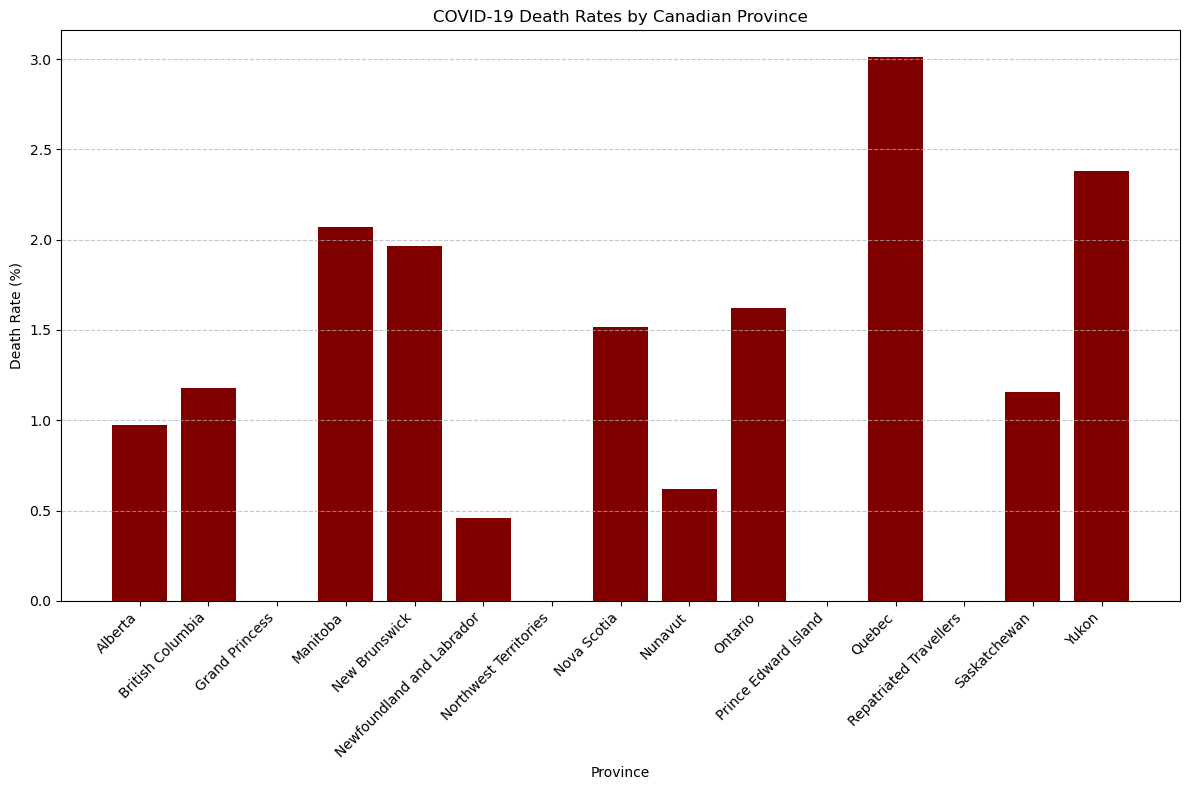

In [ ]:
latest_date = confirmed_df.columns[-1]
print(f"\nAnalyzing death rates in Canadian provinces as of {latest_date}")

canada_provinces = confirmed_df[confirmed_df['Country/Region'] == 'Canada']
death_rates = {}

for idx, row in canada_provinces.iterrows():
    province = row['Province/State']
    confirmed_cases = row[latest_date]
    
    # Find matching death data
    death_row = deaths_df[(deaths_df['Country/Region'] == 'Canada') & 
                          (deaths_df['Province/State'] == province)]
    
    if not death_row.empty and confirmed_cases > 0:
        deaths = death_row[latest_date].values[0]
        death_rate = (deaths / confirmed_cases) * 100
        death_rates[province] = death_rate
        print(f"Province: {province}, Death Rate: {death_rate:.2f}%")

if death_rates:
    highest_province = max(death_rates, key=death_rates.get)
    lowest_province = min(death_rates, key=death_rates.get)
    
    print(f"\nHighest death rate: {highest_province} at {death_rates[highest_province]:.2f}%")
    print(f"Lowest death rate: {lowest_province} at {death_rates[lowest_province]:.2f}%")
    
    # Create a bar chart of death rates
    plt.figure(figsize=(12, 8))
    provinces = list(death_rates.keys())
    rates = list(death_rates.values())
    
    plt.bar(provinces, rates, color='maroon')
    plt.title('COVID-19 Death Rates by Canadian Province')
    plt.xlabel('Province')
    plt.ylabel('Death Rate (%)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('canada_death_rates.png')
    plt.show()
else:
    print("No death rate data available for Canadian provinces")

6. Data Transformation

6.1 Transform deaths dataset from wide to long format

In [58]:
# 6. Data Transformation
print("\n6. Data Transformation:")

# 6.1 Transform deaths dataset from wide to long format
def transform_to_long_format(df):
    # Identify date columns (those after the 4th column)
    date_columns = df.columns[4:]
    
    # Create a copy to avoid modifying the original
    df_copy = df.copy()
    
    # Melt the dataframe to long format
    long_df = pd.melt(
        df_copy, 
        id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'],
        value_vars=date_columns,
        var_name='Date',
        value_name='Value'
    )
    
    # Convert date strings to datetime - use the correct format
    # For format '1/22/20', we should use '%m/%d/%y' (month/day/year)
    long_df['Date'] = pd.to_datetime(long_df['Date'], format='mixed', dayfirst=False, errors='coerce')
    
    return long_df

deaths_long = transform_to_long_format(deaths_df)
print("Deaths dataset transformed to long format:")
print(deaths_long.head())


6. Data Transformation:
Deaths dataset transformed to long format:
  Province/State Country/Region       Lat       Long       Date  Value
0        Unknown    Afghanistan  33.93911  67.709953 2020-01-22    0.0
1        Unknown        Albania  41.15330  20.168300 2020-01-22    0.0
2        Unknown        Algeria  28.03390   1.659600 2020-01-22    0.0
3        Unknown        Andorra  42.50630   1.521800 2020-01-22    0.0
4        Unknown         Angola -11.20270  17.873900 2020-01-22    0.0


6.2 Total deaths reported per country up to the current date

In [59]:
# 6.2 Total deaths reported per country up to the current date
total_deaths_by_country = deaths_long.groupby('Country/Region')['Value'].max().sort_values(ascending=False)
print("\nTotal deaths reported per country (top 10):")
print(total_deaths_by_country.head(10))


Total deaths reported per country (top 10):
Country/Region
US                594306.0
Brazil            461057.0
India             325972.0
Mexico            223455.0
United Kingdom    127775.0
Italy             126002.0
Russia            118781.0
France            108532.0
Germany            88413.0
Colombia           87747.0
Name: Value, dtype: float64


6.3 Top 5 countries with highest average daily deaths

In [60]:
# 6.3 Top 5 countries with highest average daily deaths
# First calculate daily deaths (not cumulative)
deaths_long_sorted = deaths_long.sort_values(['Country/Region', 'Province/State', 'Date'])
deaths_long_sorted['Daily_Deaths'] = deaths_long_sorted.groupby(['Country/Region', 'Province/State'])['Value'].diff().fillna(0)

# Group by country and calculate average daily deaths
avg_daily_deaths = deaths_long_sorted.groupby('Country/Region')['Daily_Deaths'].mean().sort_values(ascending=False)
print("\nTop 5 countries with highest average daily deaths:")
print(avg_daily_deaths.head(5))


Top 5 countries with highest average daily deaths:
Country/Region
US        1203.048583
Brazil     933.313765
India      659.862348
Mexico     452.338057
Italy      255.064777
Name: Daily_Deaths, dtype: float64


6.4 Evolution of total deaths over time in the United States

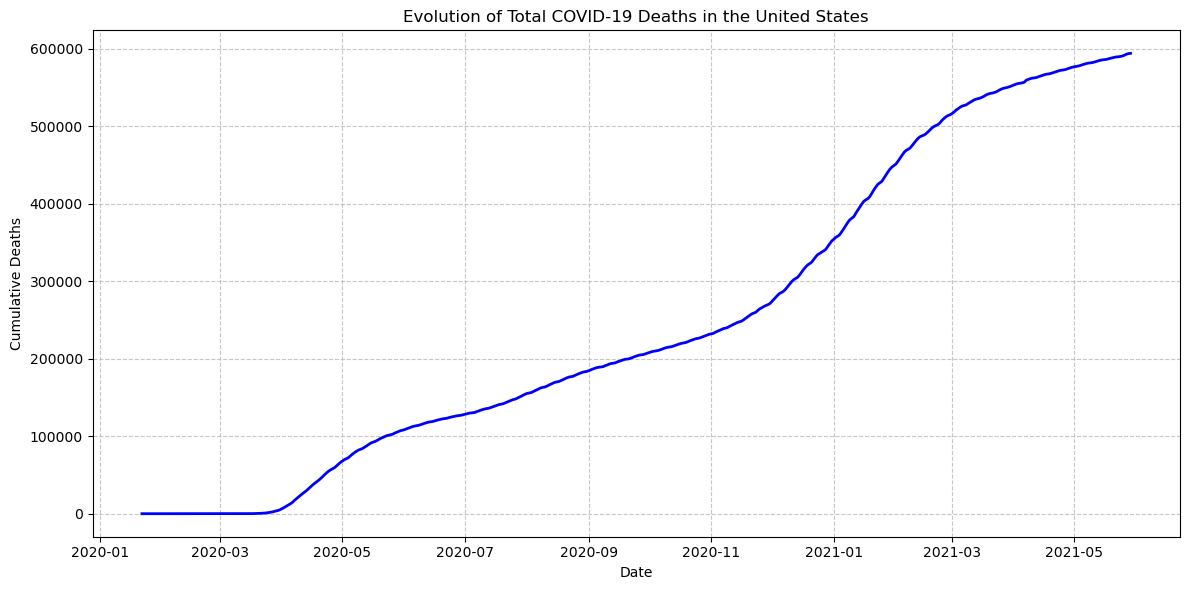

In [61]:
# 6.4 Evolution of total deaths over time in the United States
us_deaths = deaths_long[deaths_long['Country/Region'] == 'US'].copy()
us_deaths_by_date = us_deaths.groupby('Date')['Value'].sum()

plt.figure(figsize=(12, 6))
plt.plot(us_deaths_by_date.index, us_deaths_by_date.values, 'b-', linewidth=2)
plt.title('Evolution of Total COVID-19 Deaths in the United States')
plt.xlabel('Date')
plt.ylabel('Cumulative Deaths')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('us_deaths_evolution.png')
plt.show()

7. Data Merging

7.1 Merge the three datasets

In [62]:
# 7. Data Merging
print("\n7. Data Merging:")

# 7.1 Merge the three datasets
# Transform all datasets to long format
confirmed_long = transform_to_long_format(confirmed_df)
recovered_long = transform_to_long_format(recovered_df)

# Rename value columns to be more descriptive
confirmed_long = confirmed_long.rename(columns={'Value': 'Confirmed'})
deaths_long = deaths_long.rename(columns={'Value': 'Deaths'})
recovered_long = recovered_long.rename(columns={'Value': 'Recovered'})

# Merge datasets
# First merge confirmed and deaths
merged_df = pd.merge(
    confirmed_long,
    deaths_long,
    on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date'],
    how='outer'
)

# Then merge with recovered
merged_df = pd.merge(
    merged_df,
    recovered_long,
    on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date'],
    how='outer'
)

# Fill any missing values that might occur due to the merge
merged_df = merged_df.fillna(0)

print("Merged dataset:")
print(merged_df.head())
print(f"Shape of merged dataset: {merged_df.shape}")


7. Data Merging:
Merged dataset:
  Province/State Country/Region       Lat       Long       Date  Confirmed  \
0        Unknown    Afghanistan  33.93911  67.709953 2020-01-22        0.0   
1        Unknown        Albania  41.15330  20.168300 2020-01-22        0.0   
2        Unknown        Algeria  28.03390   1.659600 2020-01-22        0.0   
3        Unknown        Andorra  42.50630   1.521800 2020-01-22        0.0   
4        Unknown         Angola -11.20270  17.873900 2020-01-22        0.0   

   Deaths  Recovered  
0     0.0        0.0  
1     0.0        0.0  
2     0.0        0.0  
3     0.0        0.0  
4     0.0        0.0  
Shape of merged dataset: (139308, 8)


7.2 Analyze monthly progression of pandemic

In [65]:
# 7.2 Analyze monthly progression of pandemic
# Add month column
merged_df['Year_Month'] = merged_df['Date'].dt.strftime('%Y-%m')

# Group by month and country, sum the metrics
monthly_by_country = merged_df.groupby(['Year_Month', 'Country/Region']).agg({
    'Confirmed': 'sum',
    'Deaths': 'sum',
    'Recovered': 'sum'
}).reset_index()

print("\nMonthly progression by country (sample):")
print(monthly_by_country.head())


Monthly progression by country (sample):
  Year_Month Country/Region  Confirmed  Deaths  Recovered
0    2020-01    Afghanistan        0.0     0.0        0.0
1    2020-01        Albania        0.0     0.0        0.0
2    2020-01        Algeria        0.0     0.0        0.0
3    2020-01        Andorra        0.0     0.0        0.0
4    2020-01         Angola        0.0     0.0        0.0


7.3 Analyze for US, Italy, and Brazil

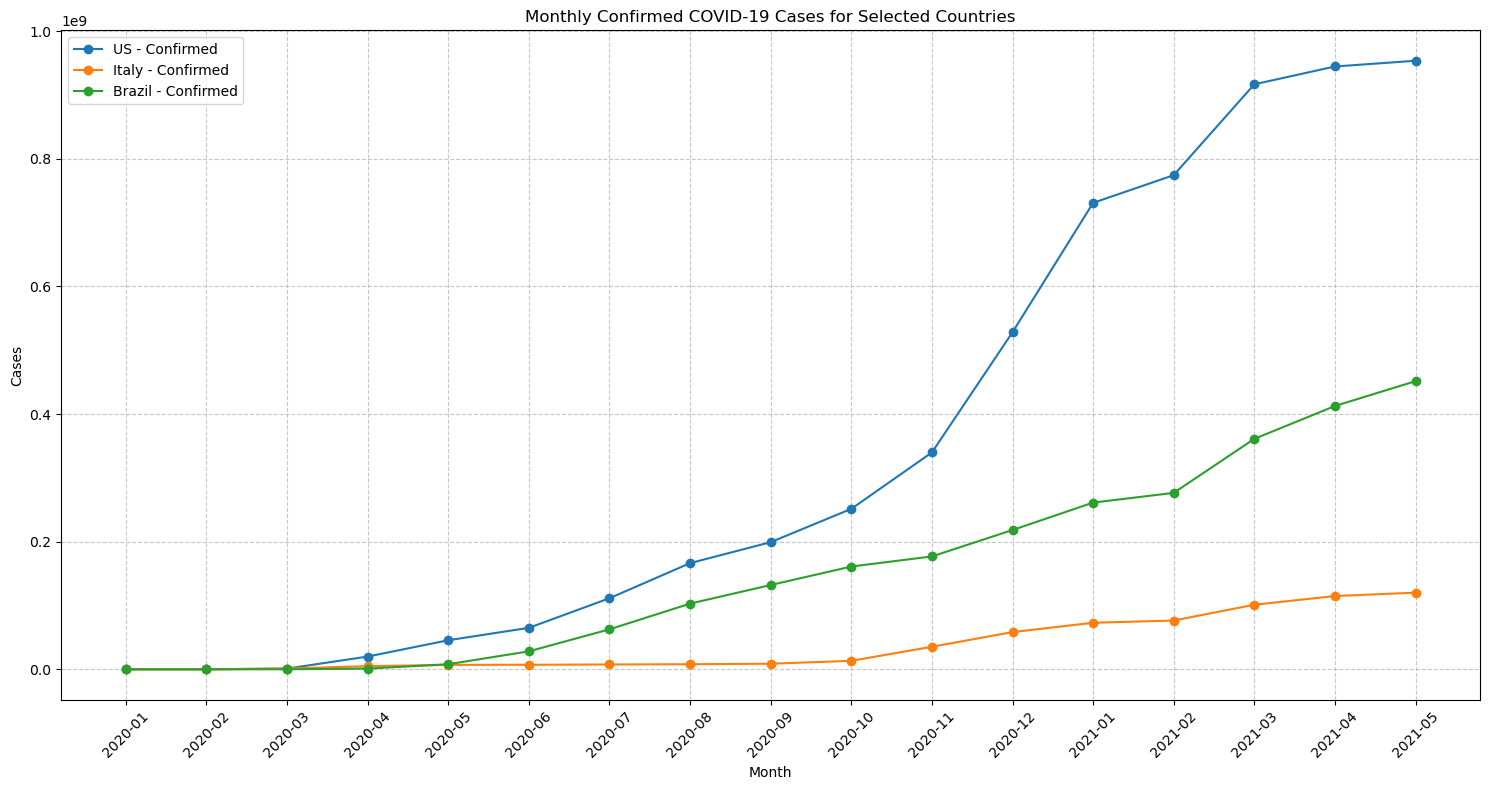

In [67]:
# 7.3 Analyze for US, Italy, and Brazil
countries_of_interest = ['US', 'Italy', 'Brazil']
monthly_selected = monthly_by_country[monthly_by_country['Country/Region'].isin(countries_of_interest)]

# Pivot for easier plotting
monthly_pivot = monthly_selected.pivot(index='Year_Month', columns='Country/Region', values=['Confirmed', 'Deaths', 'Recovered'])

# Plot confirmed cases
plt.figure(figsize=(15, 8))

for country in countries_of_interest:
    if ('Confirmed', country) in monthly_pivot.columns:
        plt.plot(monthly_pivot.index, monthly_pivot[('Confirmed', country)], marker='o', label=f"{country} - Confirmed")

plt.title('Monthly Confirmed COVID-19 Cases for Selected Countries')
plt.xlabel('Month')
plt.ylabel('Cases')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('monthly_confirmed_selected_countries.png')
plt.show()


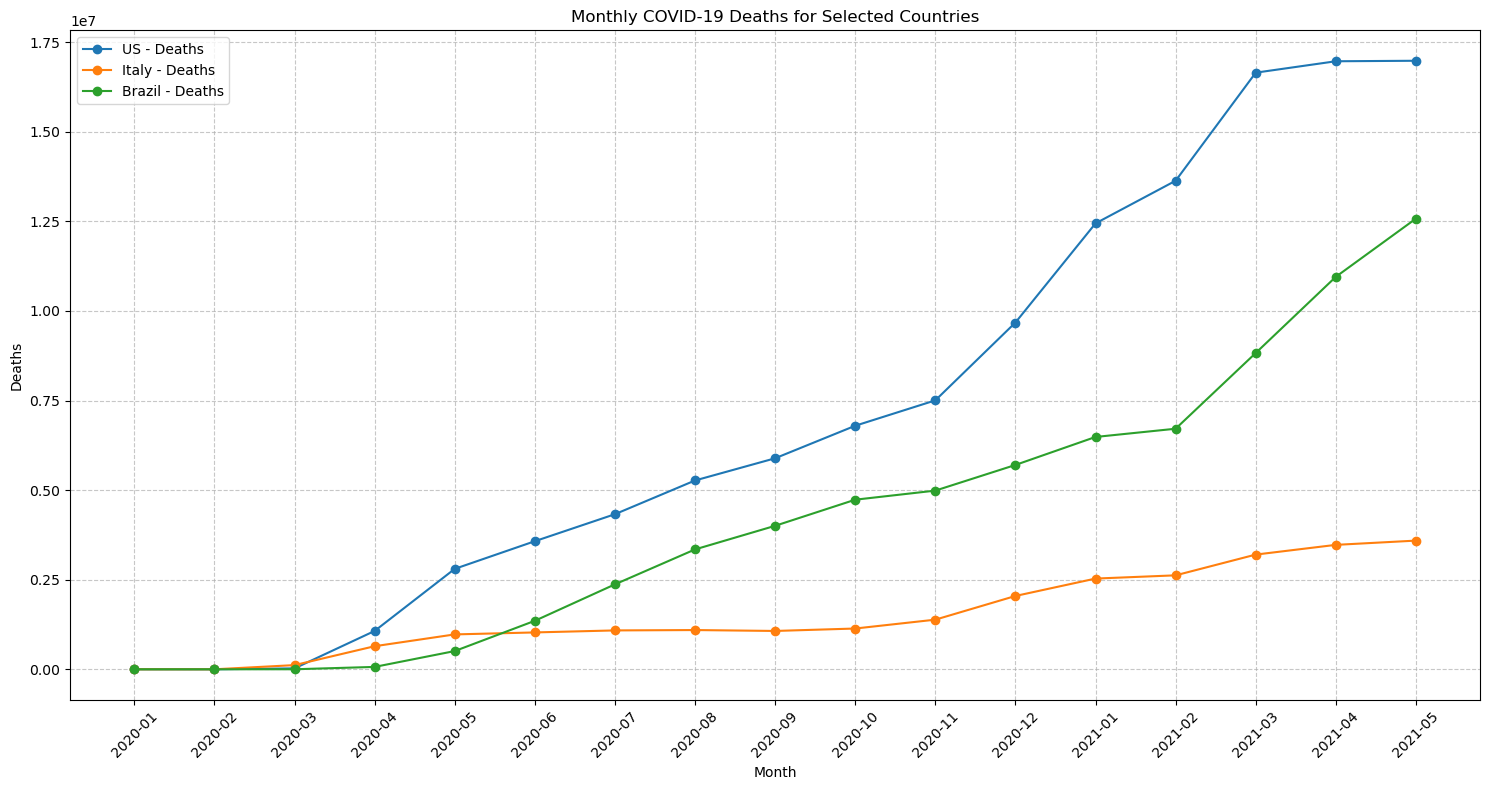

In [68]:
plt.figure(figsize=(15, 8))

for country in countries_of_interest:
    if ('Deaths', country) in monthly_pivot.columns:
        plt.plot(monthly_pivot.index, monthly_pivot[('Deaths', country)], marker='o', label=f"{country} - Deaths")

plt.title('Monthly COVID-19 Deaths for Selected Countries')
plt.xlabel('Month')
plt.ylabel('Deaths')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('monthly_deaths_selected_countries.png')
plt.show()

8. Combined Data Analysis

8.1 Three countries with highest average death rates in 2020

In [69]:
# 8. Combined Data Analysis
print("\n8. Combined Data Analysis:")

# 8.1 Three countries with highest average death rates in 2020
# Filter for 2020 data
data_2020 = merged_df[merged_df['Date'].dt.year == 2020].copy()

# Calculate death rate for each row
data_2020['Death_Rate'] = np.where(data_2020['Confirmed'] > 0, 
                                   data_2020['Deaths'] / data_2020['Confirmed'], 
                                   0)

# Group by country and calculate average death rate
avg_death_rates = data_2020.groupby('Country/Region')['Death_Rate'].mean().sort_values(ascending=False)

# Filter out countries with very few cases to avoid statistical anomalies
min_case_threshold = 1000
countries_above_threshold = data_2020.groupby('Country/Region')['Confirmed'].max() >= min_case_threshold
valid_countries = countries_above_threshold[countries_above_threshold].index

avg_death_rates_filtered = avg_death_rates[avg_death_rates.index.isin(valid_countries)]

print("\nTop 3 countries with highest average death rates in 2020 (with at least 1000 cases):")
print(avg_death_rates_filtered.head(3))


8. Combined Data Analysis:

Top 3 countries with highest average death rates in 2020 (with at least 1000 cases):
Country/Region
United Kingdom    176.535412
France             91.511113
Netherlands        22.200475
Name: Death_Rate, dtype: float64


8.2 Compare recoveries to deaths in South Africa

In [71]:
# 8.2 Compare recoveries to deaths in South Africa
sa_data = merged_df[merged_df['Country/Region'] == 'South Africa'].copy()
sa_total_deaths = sa_data['Deaths'].max()
sa_total_recoveries = sa_data['Recovered'].max()
sa_recovery_death_ratio = sa_total_recoveries / sa_total_deaths if sa_total_deaths > 0 else 0

print(f"\nSouth Africa Analysis:\n")
print(f"Total Deaths: {sa_total_deaths:,.0f}")
print(f"Total Recoveries: {sa_total_recoveries:,.0f}")
print(f"Recovery to Death Ratio: {sa_recovery_death_ratio:.2f}")


South Africa Analysis:

Total Deaths: 56,363
Total Recoveries: 1,554,184
Recovery to Death Ratio: 27.57


8.3 Monthly recovery ratio for US


US Monthly Recovery Ratios (Mar 2020 - May 2021):
2020-03: 0.0176
2020-04: 0.0876
2020-05: 0.1915
2020-06: 0.2684
2020-07: 0.3055
2020-08: 0.3419
2020-09: 0.3789
2020-10: 0.3958
2020-11: 0.3781
2020-12: 0.1414
2021-01: 0.0000
2021-02: 0.0000
2021-03: 0.0000
2021-04: 0.0000
2021-05: 0.0000
Highest Recovery Ratio: 2020-10 (0.3958)


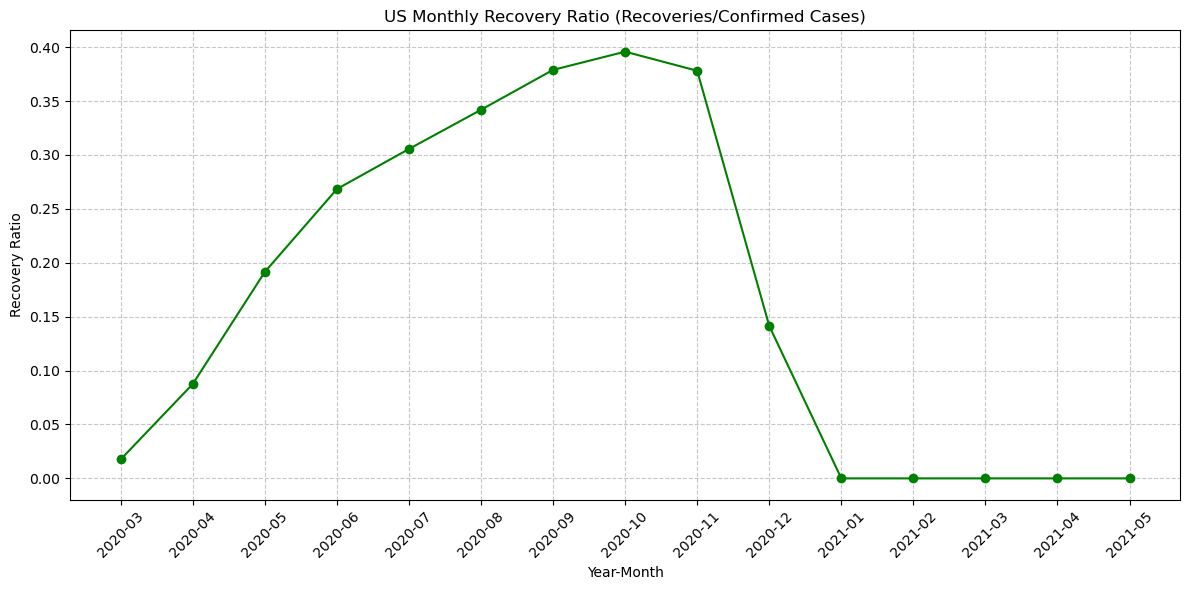


Interpretation: The highest recovery ratio may reflect improved treatments, better reporting, or vaccination effects.


In [75]:
# Filter for US, March 2020 to May 2021
us_data = merged_df[
    (merged_df['Country/Region'] == 'US') &
    (merged_df['Date'] >= '2020-03-01') &
    (merged_df['Date'] <= '2021-05-31')
].copy()  # Explicitly create a copy

# Add YearMonth column
us_data['YearMonth'] = us_data['Date'].dt.to_period('M')

# Group by Year-Month and calculate recovery ratio
monthly_ratios = us_data.groupby('YearMonth').apply(
    lambda x: (x['Recovered'].sum() / x['Confirmed'].sum()) if x['Confirmed'].sum() > 0 else 0
)

# Find highest recovery ratio
highest_month = monthly_ratios.idxmax()
highest_ratio = monthly_ratios.max()

print("\nUS Monthly Recovery Ratios (Mar 2020 - May 2021):")
for month, ratio in monthly_ratios.items():
    print(f"{month}: {ratio:.4f}")
print(f"Highest Recovery Ratio: {highest_month} ({highest_ratio:.4f})")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_ratios.index.astype(str), monthly_ratios.values, marker='o', color='green')
plt.title('US Monthly Recovery Ratio (Recoveries/Confirmed Cases)')
plt.xlabel('Year-Month')
plt.ylabel('Recovery Ratio')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('us_recovery_ratio.png')
plt.show()

# Interpretation
print("\nInterpretation: The highest recovery ratio may reflect improved treatments, better reporting, or vaccination effects.")